In [1]:
# Core libraries
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Check and set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Image size must match training
IMG_SIZE = 256

# Number of damage classes (xBD standard)
# 0: No damage
# 1: Minor
# 2: Moderate
# 3: Major
# 4: Destroyed
NUM_CLASSES = 5


In [3]:
# UNet architecture for semantic segmentation
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Conv2d(128, 64, 3, padding=1)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)

        # Output layer
        self.out = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        c1 = self.enc1(x)
        c2 = self.enc2(self.pool(c1))
        b = self.bottleneck(self.pool(c2))
        u1 = self.up1(b)
        d1 = self.dec1(torch.cat([u1, c2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, c1], dim=1))
        return self.out(d2)


In [4]:
# Initialize model
model = UNet(NUM_CLASSES).to(device)

# Load trained weights (UPDATE PATH IF NEEDED)
MODEL_PATH = r"c:\Daily drive\College\sem 6\Main Project DL\unet_damage_model.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Set model to evaluation mode
model.eval()

print("✅ Model loaded successfully")


✅ Model loaded successfully


C:\Users\samar\AppData\Local\Temp\ipykernel_2952\929223832.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=devi

In [5]:
# Jupyter-native image upload (no lag)
from ipywidgets import FileUpload
from IPython.display import display
import io
from PIL import Image

uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)


FileUpload(value={}, accept='image/*', description='Upload')

c:\Users\samar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


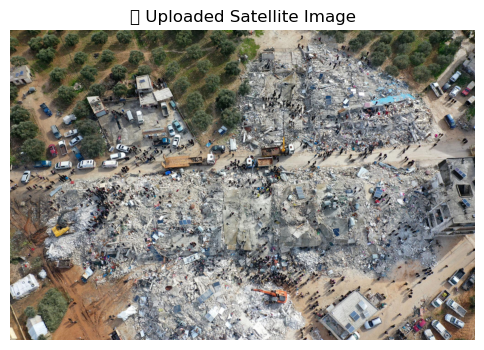

Image shape: (1365, 2048, 3)


In [7]:
# Ensure an image is uploaded
if len(uploader.value) == 0:
    raise ValueError("❌ No image uploaded")

# Read uploaded image
uploaded_file = list(uploader.value.values())[0]
img = Image.open(io.BytesIO(uploaded_file['content'])).convert("RGB")
img_rgb = np.array(img)

# Display image
plt.figure(figsize=(6,6))
plt.title("📷 Uploaded Satellite Image")
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

print("Image shape:", img_rgb.shape)


In [8]:
# Resize image to model input size
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_resized = img_resized.astype(np.float32) / 255.0  # Normalize

# Convert to PyTorch tensor
img_t = torch.from_numpy(img_resized)\
             .permute(2, 0, 1)\
             .unsqueeze(0)\
             .to(device)

# Run inference
with torch.no_grad():
    pred = model(img_t)
    mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

# Debug: show predicted classes
unique, counts = np.unique(mask, return_counts=True)
print("Predicted class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels")


Predicted class distribution:
Class 0: 64573 pixels
Class 1: 963 pixels


c:\Users\samar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


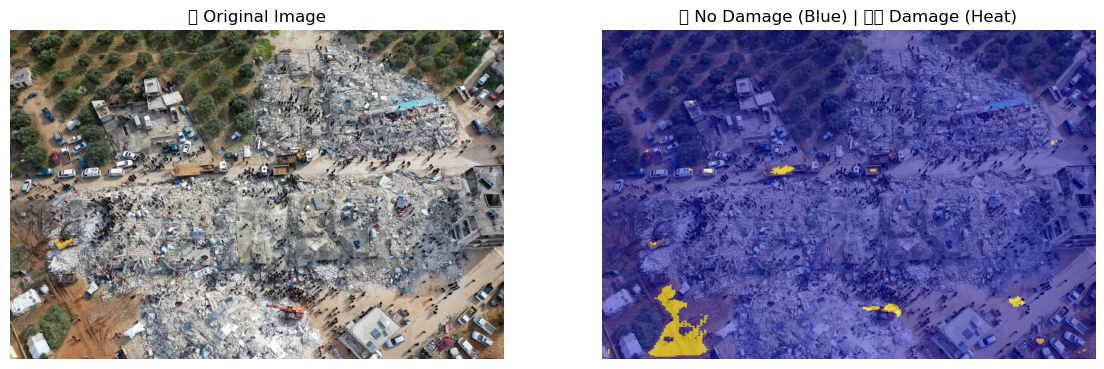

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Resize predicted mask to original image size
mask_resized = cv2.resize(
    mask.astype(np.uint8),
    (img_rgb.shape[1], img_rgb.shape[0]),
    interpolation=cv2.INTER_NEAREST
)

# --- CREATE COLOR LAYERS BASED ON MODEL OUTPUT ---

# Base canvas
colored_map = np.zeros_like(img_rgb)

# No-damage (Class 0) → BLUE
colored_map[mask_resized == 0] = (0, 0, 180)

# Damage classes → HEAT COLORS
colored_map[mask_resized == 1] = (255, 255, 0)   # Yellow (minor)
colored_map[mask_resized == 2] = (255, 165, 0)   # Orange (moderate)
colored_map[mask_resized == 3] = (255, 69, 0)    # Red-orange (major)
colored_map[mask_resized == 4] = (255, 0, 0)     # Red (destroyed)

# --- BLEND WITH ORIGINAL IMAGE ---
alpha = 0.45  # visibility strength

highlighted = (
    (1 - alpha) * img_rgb +
    alpha * colored_map
).astype(np.uint8)

# --- DISPLAY ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("📷 Original Image")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("🟦 No Damage (Blue) | 🟨🟠 Damage (Heat)")
plt.imshow(highlighted)
plt.axis("off")

plt.show()


In [14]:
unique, counts = np.unique(mask, return_counts=True)
total = mask.size

print("Predicted class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels ({round(c/total*100,2)}%)")


Predicted class distribution:
Class 0: 64573 pixels (98.53%)
Class 1: 963 pixels (1.47%)


In [10]:
# Compute destruction severity score
def destruction_scale(mask):
    total = np.sum(mask > 0)
    if total == 0:
        return 1.0

    weights = {1:2, 2:4, 3:7, 4:10}
    weighted_sum = sum(np.sum(mask == cls) * w for cls, w in weights.items())

    score = weighted_sum / total
    return round(min(max(score, 1), 10), 2)

severity_score = destruction_scale(mask)
print("🔥 Destruction Severity:", severity_score, "/ 10")


🔥 Destruction Severity: 2.0 / 10


In [11]:
# Estimate restoration cost based on damage severity
def restoration_cost(mask, severity):
    area_ratio = np.sum(mask > 0) / mask.size
    base_cost = 300_000          # ₹3 lakh
    max_cost = 5_000_000         # ₹50 lakh
    return int(base_cost + area_ratio * max_cost * (severity / 10))

estimated_cost = restoration_cost(mask, severity_score)
print(f"💰 Estimated Restoration Cost: ₹{estimated_cost:,}")


💰 Estimated Restoration Cost: ₹314,694


c:\Users\samar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\samar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\samar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


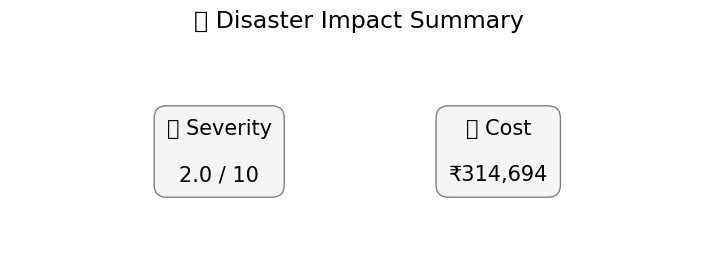

In [12]:
# Summary dashboard
fig, ax = plt.subplots(figsize=(9,3))
ax.axis("off")

card = dict(boxstyle="round,pad=0.6", facecolor="#F5F5F5", edgecolor="gray")

ax.text(0.3, 0.5,
        f"🔥 Severity\n\n{severity_score} / 10",
        ha="center", va="center", fontsize=15, bbox=card)

ax.text(0.7, 0.5,
        f"💰 Cost\n\n₹{estimated_cost:,}",
        ha="center", va="center", fontsize=15, bbox=card)

plt.title("📊 Disaster Impact Summary", fontsize=17)
plt.show()
